In [3]:
import numpy as np
import random
from datetime import datetime
import pandas as pd
from typing import Callable 

FCALLS = 0

def clear_fcalls():
    global FCALLS
    FCALLS = 0

def test_fun(x):
    global FCALLS
    FCALLS += 1
    x1, x2 = x
    return x1**2 + x2**2 - np.cos(2.5 * np.pi * x1) - np.cos(2.5 * np.pi * x2) + 2

In [4]:
import numpy as np
import random
from datetime import datetime

def EA(N, limits, epsilon, fun : Callable ,Nmax):
    mi = 20
    lambda_ = 40
    P_x = np.random.uniform(limits[0], limits[1], (mi + lambda_, N))
    P_x_t = P_x[:mi]
    P_y = np.array([fun(x) for x in P_x_t])
    
    gen = np.random.default_rng(seed=int(datetime.now().timestamp()))
    
    generation = 0
    while generation < Nmax:
        if np.min(P_y) < epsilon:
            best_idx = np.argmin(P_y)
            return P_x[best_idx], P_y[best_idx]
        
        IFF = 1 / (P_y + 1e-10)
        s_IFF = np.sum(IFF)
        
        parents_indices = np.searchsorted(np.cumsum(IFF) / s_IFF, gen.random(lambda_))
        P_x[mi:] = P_x[parents_indices]
        
        P_x[mi:] += gen.normal(0, 1, (lambda_, N))
        
        for i in range(0, lambda_, 2):
            if i + 1 < lambda_:
                cp = gen.integers(1, N)
                P_x[mi + i, cp:], P_x[mi + i + 1, cp:] = P_x[mi + i + 1, cp:].copy(), P_x[mi + i, cp:].copy()
        
        P_x_t = P_x[mi:]
        new_fitness = np.array([fun(x) for x in P_x_t])
        if np.min(new_fitness) < epsilon:
            best_idx = np.argmin(new_fitness)
            return P_x[mi + best_idx], new_fitness[best_idx]
        
        combined_fitness = np.hstack((P_y, new_fitness))
        best_indices = np.argsort(combined_fitness)[:mi]
        P_x[:mi] = np.vstack((P_x, P_x[mi:]))[best_indices]
        P_y = combined_fitness[best_indices]
        
        generation += 1

    best_idx = np.argmin(P_y)
    return P_x[best_idx], P_y[best_idx]

# Parametry
N = 2  # liczba zmiennych
limits = np.array([[-5, -5], [5, 5]])  # limity dla każdej zmiennej jako lista dwuelementowych zakresów
epsilon = 0.001
Nmax = 1000

best_solution, best_fitness = EA(N, limits, epsilon,test_fun ,Nmax)
print(f"Best solution found: {best_solution}, with fitness: {best_fitness}")


Best solution found: [0.00493311 0.0073256 ], with fitness: 0.00248316485148381


# Testowa

In [5]:
mutacje = []
x1s = []
x2s = []
ys = []
fcalls = []
isglob = []

for mut in [0.01, 0.1, 1, 10, 100]:
    for i in range(100):
        best_solution, best_fitness = EA(N, limits, epsilon,test_fun, Nmax)
        mutacje.append(mut)
        x1s.append(best_solution[0])
        x2s.append(best_solution[1])
        ys.append(test_fun(best_solution))
        fcalls.append(FCALLS)
        if abs(best_solution[0]) < 0.25 and abs(best_solution[1]) < 0.25:
            isglob.append(True)
        else:
            isglob.append(False)
        clear_fcalls()

test_results = pd.DataFrame({"mutacje": mutacje, "x1": x1s, "x2": x2s, "y": ys,'is_glob': isglob, "fcalls": fcalls})

In [6]:
test_results

,mutacje,x1,x2,y,is_glob,fcalls
0,0.01,-0.004013,0.012520,0.005500,True,80041
1,0.01,0.006162,0.005738,0.002257,True,40021
2,0.01,-0.008703,0.003289,0.002755,True,40021
3,0.01,-0.004741,0.003822,0.001181,True,40021
4,0.01,0.000558,-0.002763,0.000253,True,541
...,...,...,...,...,...,...
495,100.00,0.002310,0.004004,0.000680,True,2741
496,100.00,0.001622,-0.000128,0.000084,True,13661
497,100.00,-0.008279,-0.002249,0.002343,True,40021
498,100.00,-0.002678,0.013991,0.006455,True,40021


In [7]:
test_results.groupby("mutacje").mean()

,x1,x2,y,is_glob,fcalls
mutacje,,,,,
0.01,0.000197,-0.000270,0.001518,1.0,29441.2
0.10,-0.000023,0.000417,0.001470,1.0,27071.0
1.00,0.000221,0.000437,0.001642,1.0,30404.2
10.00,0.000703,0.000521,0.001617,1.0,28187.4
100.00,-0.000341,0.000629,0.001574,1.0,30629.8


ValueError: too many values to unpack (expected 2)

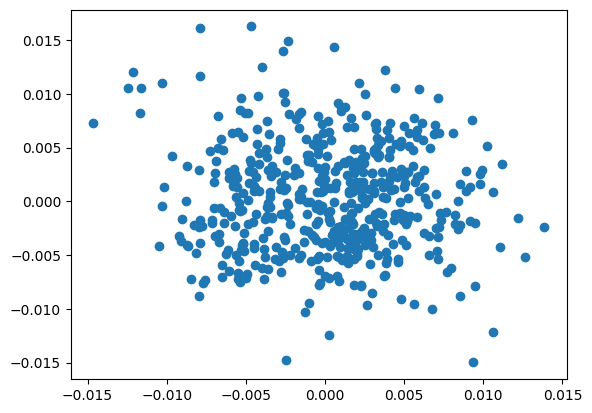

In [8]:
import matplotlib.pyplot as plt

plt.scatter(test_results["x1"], test_results["x2"])

lim = 1

# Generate grid for heatmap
x = np.linspace(-lim, lim, 100)
y = np.linspace(-lim, lim, 100)
X, Y = np.meshgrid(x, y)

# Compute Z values for the heatmap
# We need to reshape X and Y to pass them correctly into fit_fun
Z = test_fun(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

# Create the heatmap
# Note: origin='lower' ensures the (0,0) point is at the bottom left of the plot
plt.imshow(Z, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto', cmap='viridis')

# Optionally add a colorbar to show the mapping from color to function value
plt.colorbar()
plt.title("Heatmapa funkcji testowej ze znalezionymi minimami")
plt.xlabel('x1')
plt.ylabel('x2')

# Show the plot
plt.show()

# Rzeczywista

In [9]:
polo_df = pd.read_csv("polozenia.csv")
polo_df.index = polo_df.index / 10
polo_df

,x1,x2
0.0,0.000000,0.000000
0.1,0.000016,0.000984
0.2,0.000127,0.003871
0.3,0.000420,0.008570
0.4,0.000974,0.014994
...,...,...
99.6,1.000020,1.999790
99.7,1.000060,1.999850
99.8,1.000100,1.999910
99.9,1.000140,1.999980


In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_position(df: pd.DataFrame):
    # Ustawiamy ciemny styl
    plt.style.use('dark_background')
    
    # Tworzymy figurę z określonym rozmiarem
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Ustawienia tytułu i etykiet osi
    ax.set_title("Położenie ciężarków w symulacji", fontsize=14)
    ax.set_xlabel("Czas [s]", fontsize=12)
    ax.set_ylabel("Położenie [m]", fontsize=12)

    # Rysujemy serie danych z wybranymi kolorami, markerami itd.
    ax.plot(df.index, df["x1"], 
            color='cyan', marker='o', linewidth=2, markersize=4, label="x1")
    ax.plot(df.index, df["x2"], 
            color='magenta', marker='s', linewidth=2, markersize=4, label="x2")
    
    # Dodajemy legendę i siatkę pomocniczą
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Wyświetlamy wykres
    plt.show()


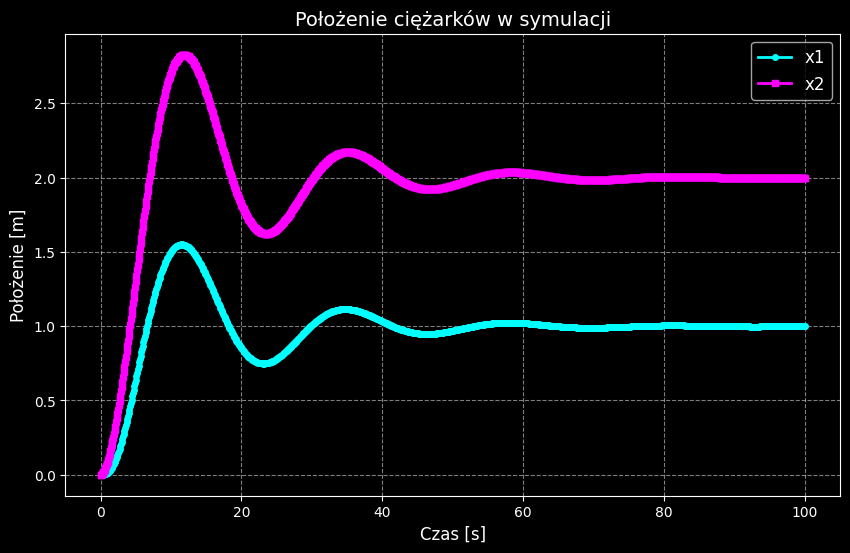

In [13]:
plot_position(polo_df)

In [14]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

def symulacja(B):
    b1, b2 = B
    
    t_end, dt, m1, m2, k1, k2, F = 100, 0.1, 5, 5, 1, 1, 1

    x1_initial = 0
    x2_initial = 0
    v1_initial = 0
    v2_initial = 0
    initial_conditions = [x1_initial, v1_initial, x2_initial, v2_initial]

    def equations(t, y, m1, m2, k1, k2, F, b1, b2):
        x1, v1, x2, v2 = y
        dx1dt = v1
        dv1dt = (-b1 * v1 - b2 * (v1 - v2) - k1 * x1 - k2 * (x1 - x2)) / m1
        dx2dt = v2
        dv2dt = (F + b2 * (v1 - v2) + k2 * (x1 - x2)) / m2
        return [dx1dt, dv1dt, dx2dt, dv2dt]

    t = np.arange(0, t_end + dt, dt)

    # Rozwiązanie równania różniczkowego
    sol = solve_ivp(equations, [0, t_end], initial_conditions, t_eval=t, args=(m1, m2, k1, k2, F, b1, b2))

    df = pd.DataFrame({
        'x1': sol.y[0],
        'x2': sol.y[2]
    })

    df.index = sol.t

    return df

# find optimal b1 and b2

In [15]:
def cost_function(b):
    global FCALLS
    FCALLS += 1
    simulated_data = symulacja(b)
    error = np.mean((simulated_data['x1'] - polo_df['x1'])**2 + (simulated_data['x2'] - polo_df['x2'])**2)
    return error

# Parametry
N = 2  
limits = np.array([[0.1, 0.1], [3, 3]])
epsilon = 0.00001
Nmax = 10000

clear_fcalls()
best_solution, best_fitness = EA(N, limits, epsilon, cost_function, Nmax)
print(f"Best solution found: {best_solution}, with fitness: {best_fitness}, Fcalls: {FCALLS}")

Best solution found: [1.52016349 2.43433034], with fitness: 4.210745306987319e-06, Fcalls: 1020


In [16]:
df_sim = symulacja(best_solution)
df_sim

,x1,x2
0.0,0.000000,0.000000
0.1,0.000016,0.000984
0.2,0.000124,0.003874
0.3,0.000411,0.008579
0.4,0.000952,0.015017
...,...,...
99.6,0.999970,1.999728
99.7,1.000010,1.999790
99.8,1.000049,1.999852
99.9,1.000087,1.999913


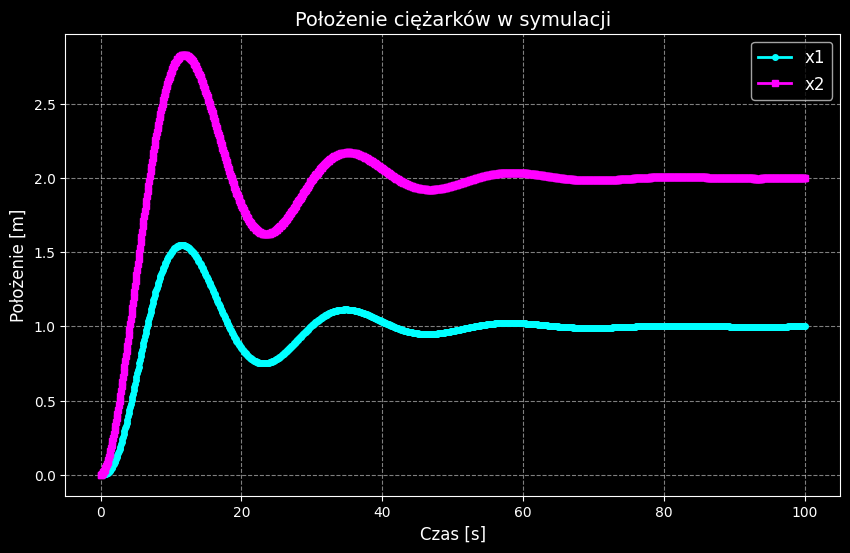

In [17]:
plot_position(df_sim)

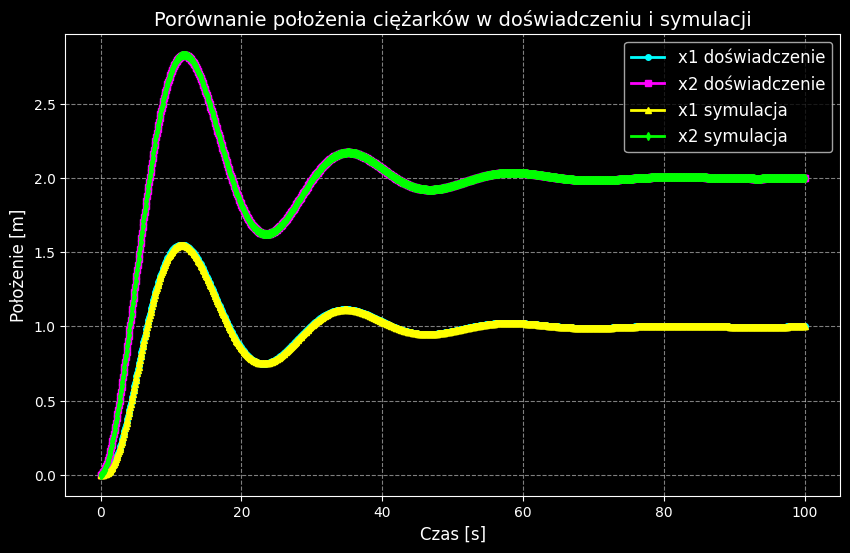

In [20]:
plt.style.use('dark_background')
    
# Tworzymy figurę o określonym rozmiarze
fig, ax = plt.subplots(figsize=(10, 6))
    
# Ustawienia tytułu i etykiet
ax.set_title("Porównanie położenia ciężarków w doświadczeniu i symulacji", fontsize=14)
ax.set_xlabel("Czas [s]", fontsize=12)
ax.set_ylabel("Położenie [m]", fontsize=12)
    
# Rysujemy dane z doświadczenia
ax.plot(
    polo_df.index, polo_df["x1"],
    color='cyan', marker='o', linewidth=2, markersize=4,
    label="x1 doświadczenie"
)
ax.plot(
        polo_df.index, polo_df["x2"],
        color='magenta', marker='s', linewidth=2, markersize=4,
        label="x2 doświadczenie"
    )
    
# Rysujemy dane z symulacji
ax.plot(
        df_sim.index, df_sim["x1"],
        color='yellow', marker='^', linewidth=2, markersize=4,
        label="x1 symulacja"
    )
ax.plot(
        df_sim.index, df_sim["x2"],
        color='lime', marker='d', linewidth=2, markersize=4,
        label="x2 symulacja"
    )
    
# Dodajemy legendę i siatkę
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
    
    # Wyświetlamy wykres
plt.show()

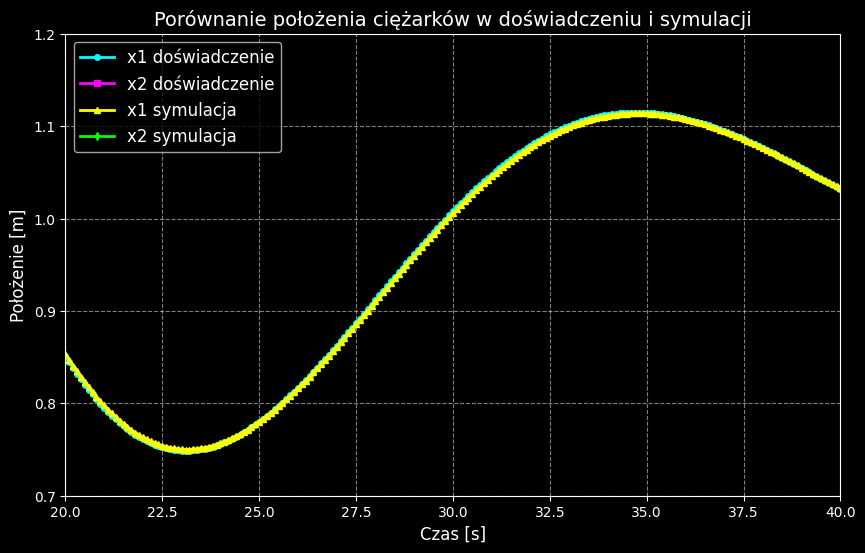

In [22]:
lim = 1

plt.style.use('dark_background')
    
    # Tworzymy figurę o określonym rozmiarze
fig, ax = plt.subplots(figsize=(10, 6))
    
 # Tytuł i etykiety osi
ax.set_title("Porównanie położenia ciężarków w doświadczeniu i symulacji", fontsize=14)
ax.set_xlabel("Czas [s]", fontsize=12)
ax.set_ylabel("Położenie [m]", fontsize=12)
    
    # Wykresy - kolory i markery można oczywiście zmodyfikować
ax.plot(
        polo_df.index, polo_df["x1"],
        color='cyan', marker='o', linewidth=2, markersize=4,
        label="x1 doświadczenie"
    )
ax.plot(
        polo_df.index, polo_df["x2"],
        color='magenta', marker='s', linewidth=2, markersize=4,
        label="x2 doświadczenie"
    )
ax.plot(
        df_sim.index, df_sim["x1"],
        color='yellow', marker='^', linewidth=2, markersize=4,
        label="x1 symulacja"
    )
ax.plot(
        df_sim.index, df_sim["x2"],
        color='lime', marker='d', linewidth=2, markersize=4,
        label="x2 symulacja"
    )
    
    # Ograniczenia zakresów osi:
ax.set_xlim(20, 40)     # Zakres na osi X od 20 do 40
ax.set_ylim(0.7, 1.2)   # Zakres na osi Y od 0.7 do 1.2
    
# Legenda i siatka
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
    
    # Wyświetlamy wykres
plt.show()

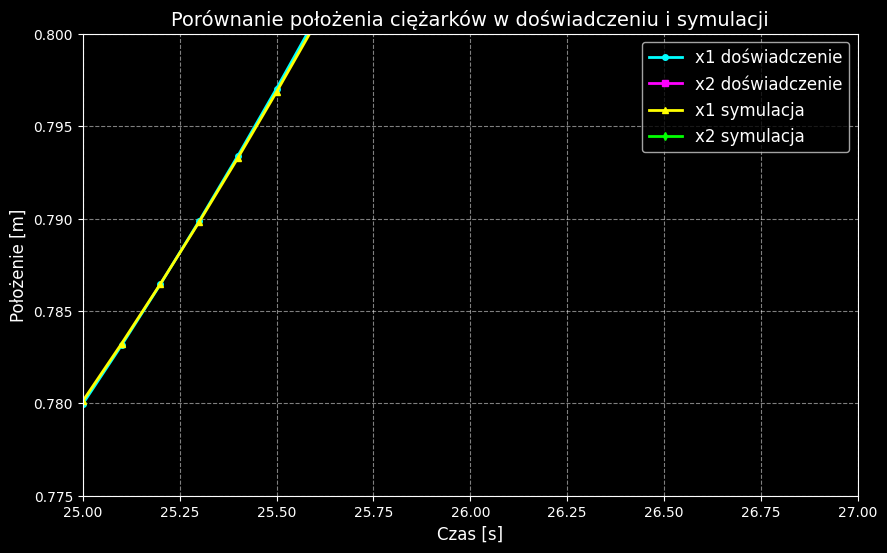

In [23]:
lim = 1

plt.style.use('dark_background')
    
    # Tworzymy figurę o określonym rozmiarze
fig, ax = plt.subplots(figsize=(10, 6))
    
    # Tytuł i etykiety osi
ax.set_title("Porównanie położenia ciężarków w doświadczeniu i symulacji", fontsize=14)
ax.set_xlabel("Czas [s]", fontsize=12)
ax.set_ylabel("Położenie [m]", fontsize=12)
    
    # Rysowanie danych z doświadczenia
ax.plot(
        polo_df.index, polo_df["x1"],
        color='cyan', marker='o', linewidth=2, markersize=4,
        label="x1 doświadczenie"
    )
ax.plot(
        polo_df.index, polo_df["x2"],
        color='magenta', marker='s', linewidth=2, markersize=4,
        label="x2 doświadczenie"
    )
    
    # Rysowanie danych z symulacji
ax.plot(
        df_sim.index, df_sim["x1"],
        color='yellow', marker='^', linewidth=2, markersize=4,
        label="x1 symulacja"
    )
ax.plot(
        df_sim.index, df_sim["x2"],
        color='lime', marker='d', linewidth=2, markersize=4,
        label="x2 symulacja"
    )

    # Ustawienia zakresów osi
ax.set_xlim(25, 27)
ax.set_ylim(0.775, 0.8)
    
    # Dodanie legendy i siatki
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
    
    # Wyświetlenie wykresu
plt.show()

In [68]:
df_sim[['x1','x2']].to_csv("symulacja.csv", index = False) 